# <p style="text-align: center;">Base Model for TP2 - Do you need more signs?</p>

### **1. Import the Required Libraries**

In [203]:
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image # Install Pillow -> conda install anaconda::pillow or pip install pillow
import os
from skimage.io import  imread, imshow # Install scikit-image -> conda install scikit-image or pip install scikit-image
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import re
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader, Subset
from sklearn.model_selection import train_test_split
import numpy as np

### **2. Load the Image Training and Test Datasets**

#### **i. Get the Image Dataset Paths**

In [204]:
train_dataset_path = 'data-students/TRAIN/'
test_dataset_path = 'data-students/TEST'


### ii. Load Image Datasets 

We are going for the tiny version of the dataset!

In [205]:
IMG_WIDTH = 75
IMG_HEIGHT = 75
BATCH_SIZE = 32

Loading the training dataset. Via DataGenerators

In [206]:
transform = transforms.Compose([transforms.Resize((IMG_WIDTH, IMG_HEIGHT)),transforms.ToTensor()])
traffic_signals_dataset = datasets.ImageFolder(root=train_dataset_path, transform=transform)


Split the Training Folder in Training / Validation

In [207]:
train_idx, valid_idx = train_test_split(
    range(len(traffic_signals_dataset)),
    test_size=0.1,
    shuffle=True,
    stratify=traffic_signals_dataset.targets
)

train_subset = Subset(traffic_signals_dataset, train_idx)
valid_subset = Subset(traffic_signals_dataset, valid_idx)

train_dataset_loader = DataLoader(train_subset, batch_size=64, shuffle=True)
validation_dataset_loader = DataLoader(valid_subset, batch_size=64, shuffle=False)

In [208]:
training_targets = traffic_signals_dataset.targets
t_targets = {k:0 for k in training_targets}
for t in training_targets:
    t_targets[t] += 1
print('Training class distribution:', t_targets)

Training class distribution: {0: 12, 1: 10, 2: 8, 3: 30, 4: 34, 5: 30, 6: 9, 7: 10, 8: 56, 9: 78}


Loading the test dataset.

In [209]:
class TestDataset(Dataset):
    def get_int(self, text):
        return [int(c) if c.isdigit() else c for c in re.split('(\d+)', text)]
    
    def __init__(self, images_folder, transform=None):
        self.images_folder = images_folder
        self.image_files = [f for f in os.listdir(images_folder) if os.path.isfile(os.path.join(images_folder, f))]
        self.image_files.sort(key=self.get_int)
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = os.path.join(self.images_folder, self.image_files[idx])
        image = Image.open(img_name).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image

inference_dataset = TestDataset(images_folder=test_dataset_path, transform=transform)

test_dataset_loader = DataLoader(inference_dataset, batch_size=BATCH_SIZE, shuffle=False)

#### **iii. Get the Label Mappings**

The labels dictionary is made in order to retrive the class names against the label indices used for training the model

In [210]:
### subset version
#the_labels = {value for _, value in train_datagen.class_to_idx.items()}
labels = {value: key for key, value in traffic_signals_dataset.class_to_idx.items()}
print(labels)
the_real_labels = {}
with open("data-students/labels.csv","r") as label_f:
    for line in label_f.readlines()[1:]:
        label_value, label_description = line.strip().split(";")
        the_real_labels[int(label_value)] = label_description 

print(the_real_labels)

print("Label Mappings for classes present in the training and validation datasets\n")
for key, value in labels.items():
    print(f"{key} : {value} - {the_real_labels[int(value)]}")
the_labels_map = {key: value for key, value in traffic_signals_dataset.class_to_idx.items()}
print(len(labels))

{0: '12', 1: '13', 2: '24', 3: '38', 4: '39', 5: '44', 6: '46', 7: '49', 8: '50', 9: '6'}
{6: 'Speed limit (70km/h)', 12: 'Dont Go Left or Right', 13: 'Dont Go Right', 22: 'Cenas', 24: 'Go Right', 37: 'Children crossing', 38: 'Dangerous curve to the right', 39: 'Dangerous curve to the left', 44: 'Go left or straight', 46: 'Unknown', 49: 'Unk1', 50: 'Fences', 54: 'Do Not Park', 55: 'Do', 57: 'Forbidden'}
Label Mappings for classes present in the training and validation datasets

0 : 12 - Dont Go Left or Right
1 : 13 - Dont Go Right
2 : 24 - Go Right
3 : 38 - Dangerous curve to the right
4 : 39 - Dangerous curve to the left
5 : 44 - Go left or straight
6 : 46 - Unknown
7 : 49 - Unk1
8 : 50 - Fences
9 : 6 - Speed limit (70km/h)
10


### **2. Plotting Sample Training Images**

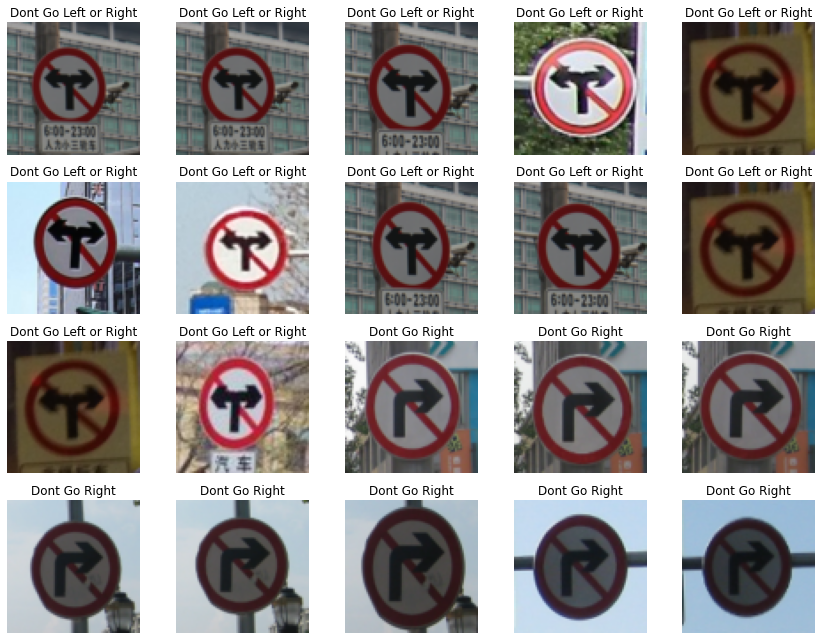

In [211]:
fig, ax = plt.subplots(nrows=4, ncols=5, figsize=(12, 9))
dataiter = iter(traffic_signals_dataset)
idx = 0

for i in range(4):
    for j in range(5):
        images, l = next(dataiter)
        img = images
        label = the_real_labels[int(labels[l])]
        ax[i, j].set_title(f"{label}")
        ax[i, j].imshow(img.permute(1,2,0))
        ax[i, j].axis("off")
        idx += 1

plt.tight_layout()
#plt.suptitle("Sample Training Images", fontsize=21)
plt.show()

In [212]:
class CustomCNN(nn.Module):
    def __init__(self, img_width, img_height, num_classes):
        super(CustomCNN, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=128, kernel_size=5, padding='valid')
        self.bn1 = nn.BatchNorm2d(num_features=128)
        
        self.conv2 = nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, padding='valid', bias=False)
        self.bn2 = nn.BatchNorm2d(num_features=64)
        
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=32, kernel_size=3, padding='valid', bias=False)
        self.bn3 = nn.BatchNorm2d(num_features=32)
        
        #self.fc1 = nn.Linear(32 * self._conv_output_shape(img_width, img_height), 256)  # Assuming square input for simplification
        self.fc1 = nn.Linear(1568,256)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(256, num_classes)
        
        # L2 regularization is not directly included in layers in PyTorch, 
        # it's typically added to the optimizer during the training step.

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.max_pool2d(x, kernel_size=2)
        
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.max_pool2d(x, kernel_size=2)
        
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.max_pool2d(x, kernel_size=2)
        
        x = torch.flatten(x, 1)  # Flatten all dimensions except batch
        
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        
        return x
    
    def _conv_output_shape(self, img_width, img_height, kernel_size=3, stride=1, padding=0, dilation=1):
        h = ((img_height + (2 * padding) - (dilation * (kernel_size - 1)) - 1) / stride) + 1
        w = ((img_width + (2 * padding) - (dilation * (kernel_size - 1)) - 1) / stride) + 1
        return int(h/8) * int(w/8)  # Considering three max pooling layers with kernel_size=2, stride=2


In [213]:
def train_model(model, criterion, optimizer,train_dataset_loader, num_epochs=10, device='cpu'):
    model.to(device)
    for epoch in range(num_epochs):
        cumulative_loss = 0
        for batch_idx, (data, target) in enumerate(train_dataset_loader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

            #if (batch_idx + 1) % 100 == 0:
            print(f'Epoch {epoch+1}/{num_epochs}, Step {batch_idx+1}/{len(train_dataset_loader)}, Loss: {loss.item():.4f}')
            cumulative_loss += loss.item()
        print(f"Epoch {epoch+1} average loss: {cumulative_loss/len(train_dataset_loader)}")
    return model.to("cpu")

In [214]:
device = torch.device("cpu")
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():    
    device = torch.device("cuda")

num_classes = len(labels)
print(num_classes)
print(device)
num_epochs = 15
model = CustomCNN(IMG_WIDTH, IMG_HEIGHT, num_classes)
criterion = nn.MSELoss()  
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)


10
cpu


In [215]:
TRAIN_MODEL = False
if TRAIN_MODEL:
    ccnn = train_model(model, criterion, optimizer, train_dataset_loader, num_epochs, device)
    
else:
    ccnn = torch.load('baseline_model.pth')

In [216]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def test_model(model, dataset_loader):
    y_real = []
    y_pred = []
    model.to(device)
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in dataset_loader:
            y_real.extend(labels.numpy())
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            y_pred.extend(predicted.cpu().numpy())
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Accuracy of the model on the {} test images: {} %'.format(total,100 * correct / total))
    # Generate the confusion matrix
    cm = confusion_matrix(y_real, y_pred)

    # Display the confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.show()

Accuracy of the model on the 28 test images: 71.42857142857143 %


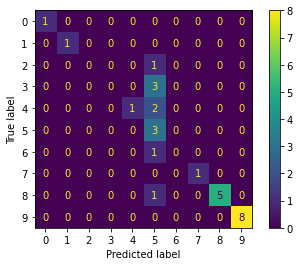

None


In [217]:
print(test_model(ccnn, validation_dataset_loader))

In [270]:
class Autoencoder(nn.Module):
    def __init__(self, color_channels=3, width=75, height=75):
        super().__init__()
        self.encoder=nn.Sequential(
            nn.Conv2d(color_channels, 16, kernel_size=3, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(16, 8, kernel_size=3, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(8, 4, kernel_size=3, stride=1, padding=1),
            nn.ReLU(True)
            )
        
        self.decoder=nn.Sequential(
            nn.ConvTranspose2d(4, 8, kernel_size=3, stride=1, padding=1),
            nn.ReLU(True),
            nn.ConvTranspose2d(8, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, color_channels, kernel_size=3, stride=2, padding=1, output_padding=0),
            nn.Tanh()
            )
        
    def forward(self,x):
        encoded=self.encoder(x)
        decoded=self.decoder(encoded)
        return decoded
    

In [271]:
def train_autoencoder(model, data_loader, num_epochs=50, device='cpu'):
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(),
                                lr=1e-3, 
                                weight_decay=1e-5)

    outputs=[]
    model = model.to(device)
    for epoch in range(num_epochs):
        for(img, _) in data_loader:
            #img=img.to(device)
            recon=model(img)
            loss=criterion(recon, img)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
        
        print(f'Epoch:{epoch+1}, Loss:{loss.item():.4f}')
        outputs.append((epoch, img, recon))
    
    return model.to('cpu'), outputs


In [272]:
autoencodermodel=Autoencoder()
autoencoder,output=train_autoencoder(autoencodermodel, train_dataset_loader, 50, device)

Epoch:1, Loss:0.2789
Epoch:2, Loss:0.2530
Epoch:3, Loss:0.2567
Epoch:4, Loss:0.2314
Epoch:5, Loss:0.2246
Epoch:6, Loss:0.2216
Epoch:7, Loss:0.1904
Epoch:8, Loss:0.1604
Epoch:9, Loss:0.1266
Epoch:10, Loss:0.1108
Epoch:11, Loss:0.0898
Epoch:12, Loss:0.0602
Epoch:13, Loss:0.0527
Epoch:14, Loss:0.0434
Epoch:15, Loss:0.0352
Epoch:16, Loss:0.0363
Epoch:17, Loss:0.0335
Epoch:18, Loss:0.0320
Epoch:19, Loss:0.0299
Epoch:20, Loss:0.0283
Epoch:21, Loss:0.0254
Epoch:22, Loss:0.0229
Epoch:23, Loss:0.0226
Epoch:24, Loss:0.0222
Epoch:25, Loss:0.0211
Epoch:26, Loss:0.0198
Epoch:27, Loss:0.0203
Epoch:28, Loss:0.0170
Epoch:29, Loss:0.0162
Epoch:30, Loss:0.0163
Epoch:31, Loss:0.0168
Epoch:32, Loss:0.0144
Epoch:33, Loss:0.0146
Epoch:34, Loss:0.0139
Epoch:35, Loss:0.0146
Epoch:36, Loss:0.0147
Epoch:37, Loss:0.0144
Epoch:38, Loss:0.0127
Epoch:39, Loss:0.0133
Epoch:40, Loss:0.0132
Epoch:41, Loss:0.0123
Epoch:42, Loss:0.0123
Epoch:43, Loss:0.0133
Epoch:44, Loss:0.0124
Epoch:45, Loss:0.0127
Epoch:46, Loss:0.01

In [273]:
def plot_results(outputs, num_epochs, color_channels=3, width=75, height=75):
    for k in range(0, num_epochs, 1):
        plt.figure(figsize=(9, 2))
        plt.gray()
        imgs = outputs[k][1].detach().numpy()
        recon = outputs[k][2].detach().numpy()

        
        for i, item in enumerate(imgs):
            if i >= 9: break
            plt.subplot(2, 9, i+1)
            plt.axis('off')

            if color_channels == 1:
                item = np.clip(item, 0.0, 1.0)
                plt.imshow(item.reshape(height, width))
            else:
                item = item.reshape(color_channels,height, width)
                item = np.clip(item, 0.0, 1.0)
                plt.imshow(np.transpose(item, (1,2,0)))
    
        for i, item in enumerate(recon):
            if i >= 9: break
            plt.subplot(2, 9, 9+i+1)
            
            plt.axis('off')
            if color_channels == 1:
                item = np.clip(item, 0.0, 1.0)
                plt.imshow(item.reshape(height, width))
            else:
                item = item.reshape(color_channels,height, width)
                item = np.clip(item, 0.0, 1.0)
                plt.imshow(np.transpose(item, (1,2,0)))



57


C:\Users\Diogo\AppData\Local\Temp\ipykernel_14572\2432029171.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(9, 2))


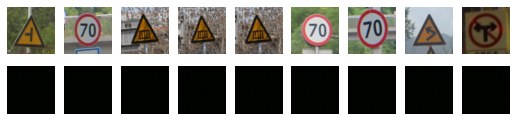

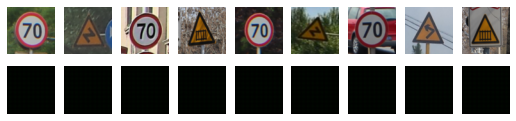

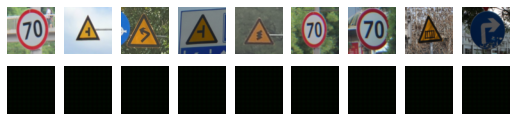

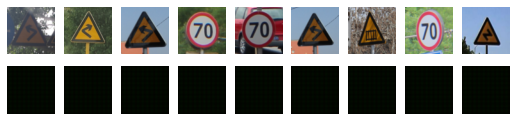

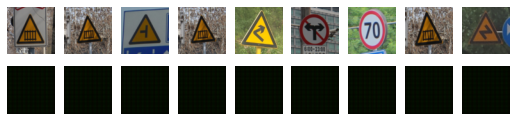

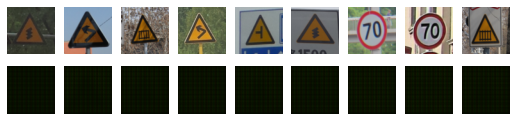

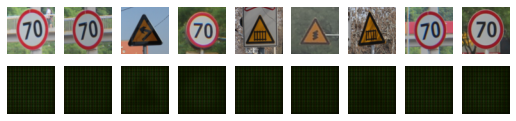

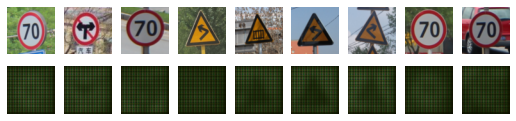

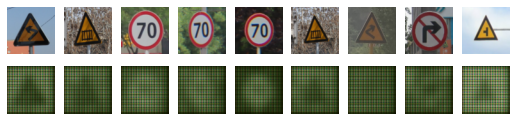

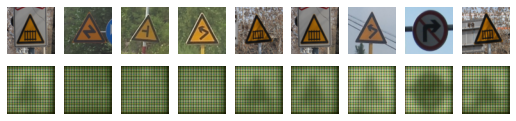

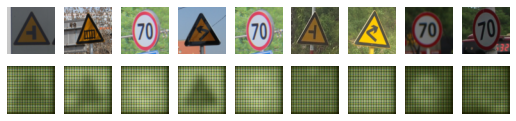

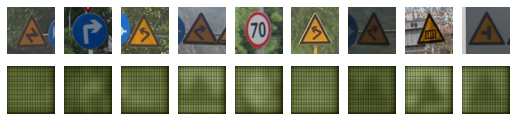

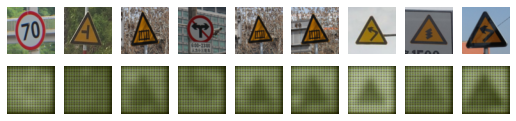

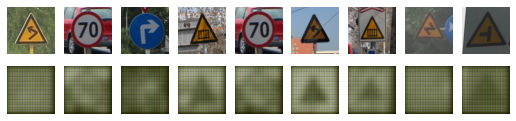

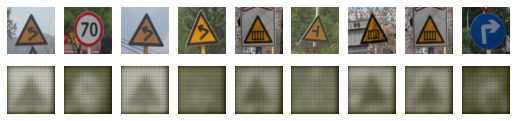

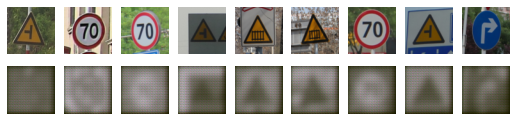

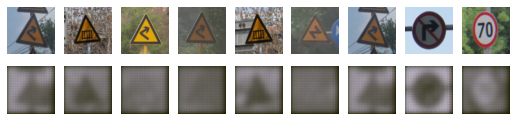

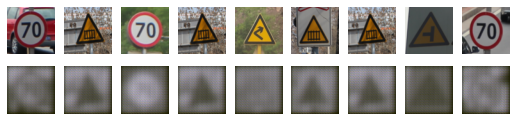

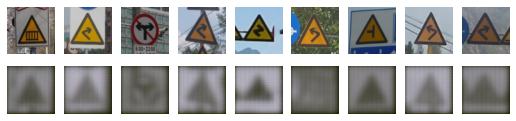

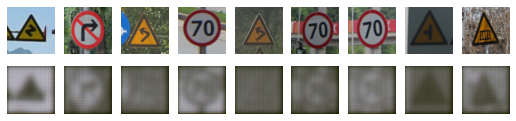

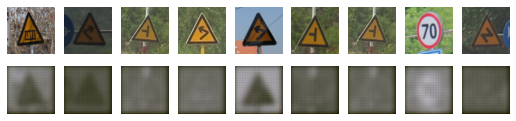

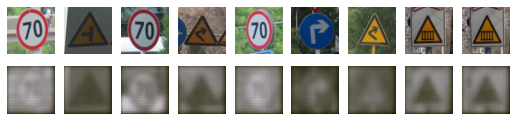

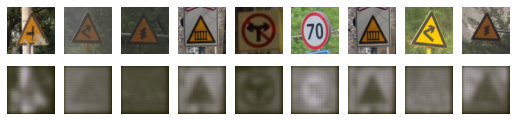

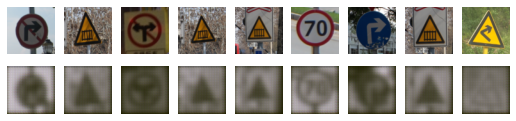

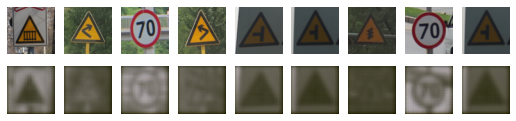

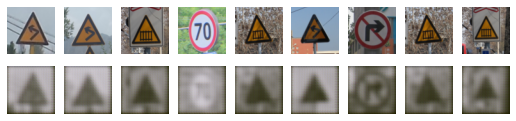

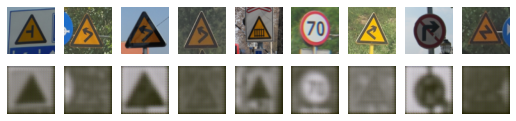

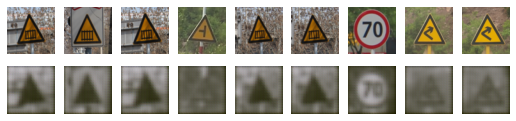

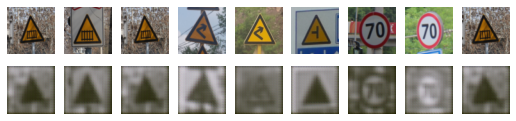

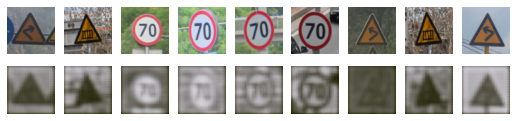

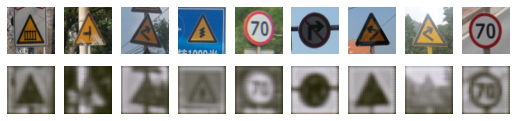

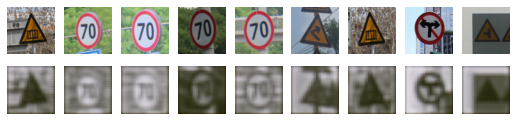

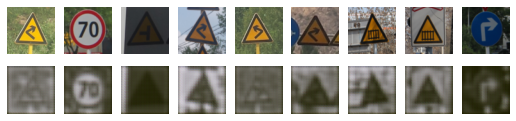

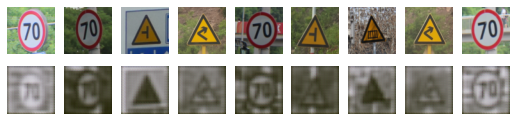

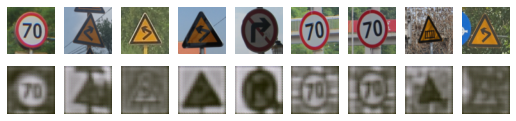

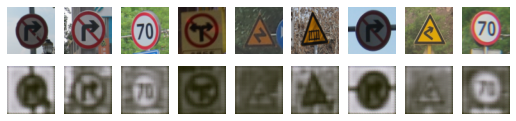

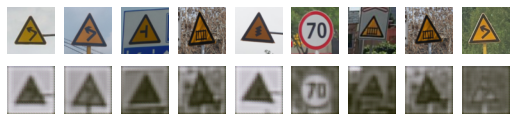

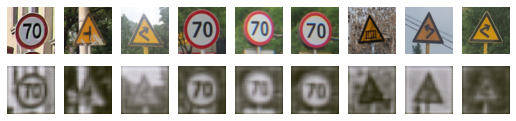

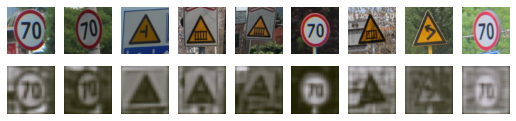

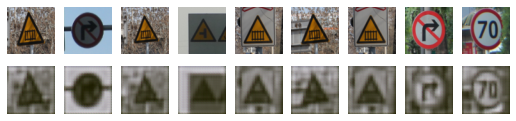

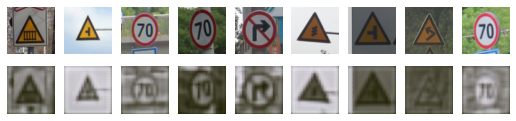

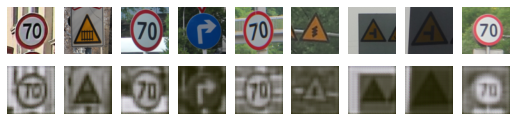

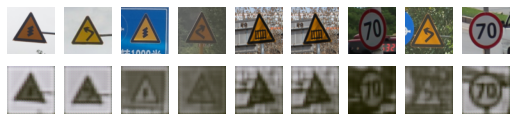

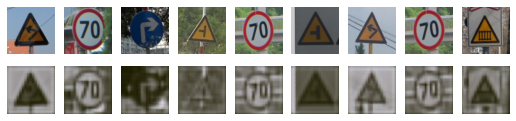

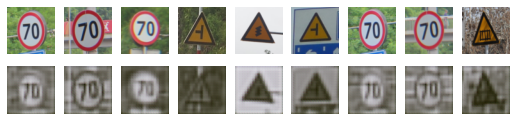

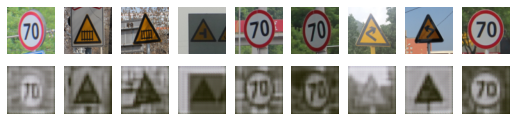

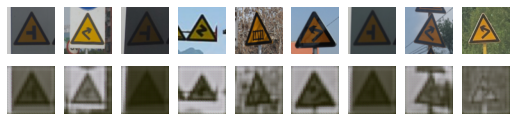

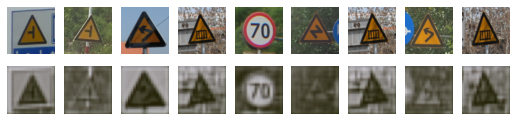

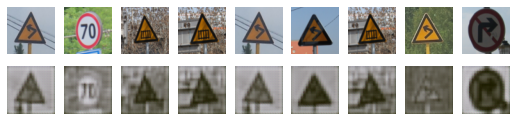

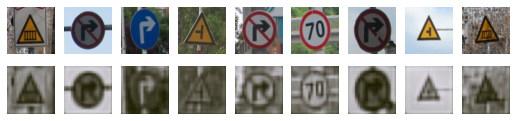

In [274]:
print(len(output[0][1]))
plot_results(output, 50, color_channels=3, width=75, height=75)